In [2]:
# Implementaremos mejoras al modelo baseline:
# 1. SMOTE para balancear las clases
# 2. Feature Engineering: nuevas variables combinadas
# 3. Tuning de hiperparámetros

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd

# Preparar el dataset original con variables adicionales
df = pd.read_csv("/Users/Usuario/Documents/CUARTO AÑO/DATA SCIENCE/Proyecto final/synthetic_fraud_dataset 2.csv")

# Feature engineering
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Weekend_Night_Flag'] = ((df['Is_Weekend'] == 1) & (df['Hour'] >= 18)).astype(int)
df['High_Amount_Flag'] = (df['Transaction_Amount'] > df['Transaction_Amount'].quantile(0.75)).astype(int)
df['Risk_x_Fails'] = df['Risk_Score'] * df['Failed_Transaction_Count_7d']

# Codificar variables categóricas
df.drop(columns=['Transaction_ID', 'User_ID', 'Timestamp'], inplace=True)
categorical_cols = ['Transaction_Type', 'Device_Type', 'Location', 'Merchant_Category', 'Card_Type', 'Authentication_Method']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Definir variables
X = df.drop(columns=['Fraud_Label'])
y = df['Fraud_Label']

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Tuning de hiperparámetros con GridSearch
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}
grid = GridSearchCV(LogisticRegression(max_iter=1000, class_weight='balanced'), param_grid, cv=5)
grid.fit(X_train_sm, y_train_sm)

# Evaluación del mejor modelo
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Métricas
metrics_improved = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC'],
    'Valor': [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_proba)
    ]
})

/Users/Usuario/miniforge3/envs/ambientecr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Usuario/miniforge3/envs/ambientecr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Usuario/miniforge3/envs/ambientecr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Usuario/miniforge3/envs/ambientecr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Usuario/miniforge3/envs/ambientecr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did 

In [3]:
print("Métricas del modelo mejorado:")
print(metrics_improved)


Métricas del modelo mejorado:
     Métrica     Valor
0   Accuracy  0.903400
1  Precision  0.796204
2     Recall  0.939932
3   F1-score  0.862118
4    ROC AUC  0.970561


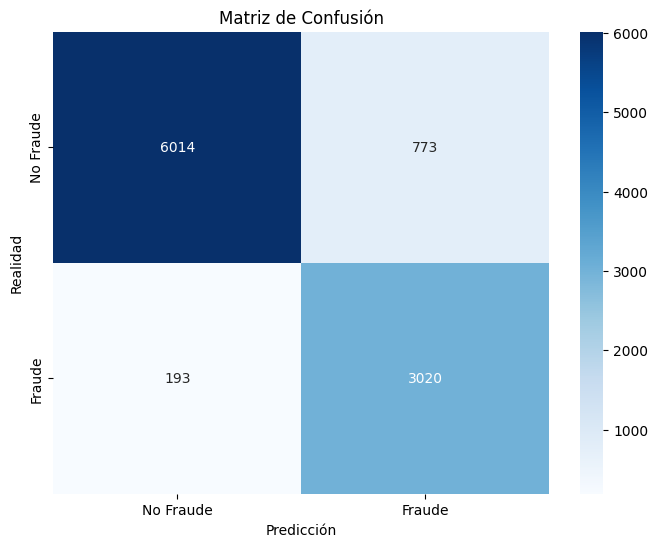

In [5]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()




